### Import the needed Python packages.

In [13]:
import os
from glob import glob
import json
import pandas as pd
import numpy as np
import yaml

In [14]:
vcdb_path = '/home/vkarthyk/Projects/QxBranch/VCDB/data/json'

### Read all the json files and store all the data in a list. The json file is loaded as a dictionary. So we create a list of dicts

In [15]:
import pprint 
incidents = []

for fullFileName in glob(vcdb_path+'/*.json'):
    try:
        incident = json.loads(open(fullFileName).read())
        incidents.append(incident)
    except:
        #print fullFileName
        continue
print len(incidents)

5706


In [16]:
pprint.pprint(incident, indent='4')

{   u'action': {   u'misuse': {   u'variety': [u'Privilege abuse'],
                                  u'vector': [u'Unknown']}},
    u'actor': {   u'internal': {   u'motive': [u'Unknown'],
                                   u'variety': [u'Unknown']}},
    u'asset': {   u'assets': [{   u'variety': u'Unknown'}]},
    u'attribute': {   u'confidentiality': {   u'data': [   {   u'variety': u'Classified'}],
                                              u'data_disclosure': u'Yes',
                                              u'state': [u'Unknown']}},
    u'discovery_method': u'Unknown',
    u'impact': {   u'overall_rating': u'Unknown'},
    u'incident_id': u'A8486A6E-EFDA-4C80-A242-EFA09DBDB1B0',
    u'plus': {   u'analysis_status': u'First pass',
                 u'analyst': u'Spitler',
                 u'attribute': {   u'confidentiality': {   u'credit_monitoring': u'U'}},
                 u'created': u'2013-10-02T14:43:00Z',
                 u'github': u'395',
                 u'master_id

### The json obtained is a very complex nested dictionary as you can see above. A lot of values in the dict were in the form of unicode, list and string. 

### So I wrote a recursive function which extracts all the final values from the data in plaintext format

In [17]:
def get_dict(dictionary):
    for key, val in dictionary.items():
        
        # If the value is again a dict, then run the function on this value
        if isinstance(val, dict):
            get_dict(val)
        
        # If the value is in unicode, then change the value of the same key to plaintext
        elif isinstance(val, unicode):
            dictionary[key] = yaml.safe_load(json.dumps(val))  
    
        # If the value is in form of list, then extract only the element in the list
        elif isinstance(val, list):
            dictionary[key] = val[0]

    return dictionary


### Create a pandas Dataframe by passing all the json dicts as arguments to the function above, and appending the returned dict as a row. Sanitizing this dict was very important so as to form the DataFrame. Otherwise, it was throwing a lot of errors.

In [18]:
df3 = pd.DataFrame()
for incident in incidents:
    
    # Create a pandas dataframe from the dictionary obtained from the recursive function
    df3 = df3.append(pd.DataFrame.from_dict(get_dict(incident)))

In [38]:
df3.head(3)

,action,actor,asset,attribute,campaign_id,discovery_method,discovery_notes,impact,incident_id,notes,plus,reference,schema_version,security_incident,source_id,summary,targeted,timeline,victim
analysis_status,NaN,NaN,NaN,NaN,NaN,Int - IT review,NaN,NaN,5159F126-C17C-47BB-951B-2CBD1F6E41D1,NaN,First pass,http://www.thetelegram.com/News/Local/2012-02-...,1.3.1,Confirmed,vcdb,"The Workplace Health, Safety and Compensation ...",NaN,NaN,NaN
analyst,NaN,NaN,NaN,NaN,NaN,Int - IT review,NaN,NaN,5159F126-C17C-47BB-951B-2CBD1F6E41D1,NaN,swidup,http://www.thetelegram.com/News/Local/2012-02-...,1.3.1,Confirmed,vcdb,"The Workplace Health, Safety and Compensation ...",NaN,NaN,NaN
asset,NaN,NaN,NaN,NaN,NaN,Int - IT review,NaN,NaN,5159F126-C17C-47BB-951B-2CBD1F6E41D1,NaN,{u'total': u'No'},http://www.thetelegram.com/News/Local/2012-02-...,1.3.1,Confirmed,vcdb,"The Workplace Health, Safety and Compensation ...",NaN,NaN,NaN



### You can see that the data obtained is really sparse and a lot of values are missing. This is because the DataFrame was formed in such a way that in every column belonging to each incident, only 1 value was present and others were missing. So I had to merge all the data in single row with unique values in every column.

### The incident_id was unique for every incident. So I made this the index for the Dataframe. And I also extracted the 1 value present in every column using the in-built last() function. The Dataframe obtained looks much better that way

In [20]:
df4 = df3.groupby('incident_id').last()
df4.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 5703 entries, 0001AA7F-C601-424A-B2B8-BE6C9F5164E7 to FFE36843-D23A-484F-A9B8-1338C9BE49CD
Data columns (total 18 columns):
action               5703 non-null object
actor                5703 non-null object
asset                5703 non-null object
attribute            5703 non-null object
campaign_id          188 non-null object
discovery_method     5703 non-null object
discovery_notes      143 non-null object
impact               4353 non-null object
notes                363 non-null object
plus                 5703 non-null object
reference            5257 non-null object
schema_version       5703 non-null object
security_incident    5703 non-null object
source_id            5703 non-null object
summary              5207 non-null object
targeted             1 non-null object
timeline             5703 non-null object
victim               5703 non-null object
dtypes: object(18)
memory usage: 846.5+ KB


### But still a lot of values in the DataFrame are present as dicts, lists, and also tuples. So to extract meaningful data I applied the below operations on every value, depending on its type.

### I also drop the column 'summary' as it is not useful for classification purposes

In [21]:
df4 = df4.applymap(lambda x: x.values() if type(x) is dict else x )
df4 = df4.applymap(lambda x: tuple(x) if type(x) is list else x )
df4 = df4.applymap(lambda x: ''.join(str(x).lstrip('(').rstrip(')')) if type(x) is tuple else x )

df4 = df4.drop('summary', axis=1)

### Write the obtained DataFrame to a csv file. I have also sent the csv file as attachment

### You can see that the data looks much more clean and meaningful now. All the missing values and extraneous data has been sanitized and removed

In [22]:
df4['timeline'] = df4['timeline'].apply(lambda x: x.split(',')[0])
df4.to_csv("vcdb_feature_set.csv", encoding='utf-8')
df4.head(3)

,action,actor,asset,attribute,campaign_id,discovery_method,discovery_notes,impact,notes,plus,reference,schema_version,security_incident,source_id,targeted,timeline,victim
incident_id,,,,,,,,,,,,,,,,,
0001AA7F-C601-424A-B2B8-BE6C9F5164E7,"u'LAN access', u'Privilege abuse'","u'Unknown', u'Unknown'","u'S - Database',","u'Fraudulent transaction',",NaN,Unknown,NaN,NaN,NaN,2015-02-13T16:50:35Z,http://vcdb.org/pdf/va-security.pdf,1.3.1,Confirmed,vcdb,NaN,2010,United States Department of Veterans Affairs
0008DADB-E83D-4278-A19A-CEE01610CF43,"u'Personal vehicle', u'Theft'","u'Financial', u'Unknown', u'000000', u'Unknown'","u'U - Laptop',","u'Patient', u'Stored unencrypted', {u'variety'...",NaN,Int - reported by employee,NaN,Unknown,NaN,"{u'year': 2014, u'day': 11, u'month': 12},",http://healthitsecurity.com/2014/12/11/laptop-...,1.3.1,Confirmed,vcdb,NaN,2014,Corvallis Clinic
000D403E-2DC9-4EA7-9294-BD3938D1C3C7,"u'Unknown', u'Loss'","u'Unknown', u'Unknown', '000', u'000000', 'Med...","u'M - Disk media',","u'Patient', u'Stored unencrypted', {u'variety'...",NaN,Ext - customer,NaN,Unknown,NaN,"{u'year': 2014, u'day': 11, u'month': 8},",http://www.njbiz.com/article/20140811/NJBIZ01/...,1.3.1,Confirmed,vcdb,NaN,2014,Jersey City Medical Center


In [23]:
df4.describe()

,action,actor,asset,attribute,campaign_id,discovery_method,discovery_notes,impact,notes,plus,reference,schema_version,security_incident,source_id,targeted,timeline,victim
count,5703,5703,5703,5703,188,5703,143,4353,363,5703,5257,5703,5703,5703,1,5703,5703
unique,567,892,192,2776,10,30,142,2,309,1299,3852,1,3,1,1,22,3945
top,"u'LAN access', u'Privilege abuse'","u'NA', u'Unknown'","u'M - Documents',","{u'variety': u'Unknown'}, 1, 'Yes'",CBAA666B-8213-4F6B-B6AC-29896A9C1455,Unknown,External: Unaffiliated,Unknown,The Sejong Institute,"{},",http://vcdb.org/pdf/va-security.pdf,1.3.1,Confirmed,vcdb,Targeted,2013,United States Department of Veterans Affairs
freq,505,1211,1146,422,89,3409,2,4352,13,352,751,5703,5654,5703,1,1865,867


### I then removed the columns which are not helpful for classification. As you can see above, columns like description notes and summary do not give useful metrics for classification. There are also other columns like source_id and schema_version which have just 1 value. So I removed these from the DataFrame

In [24]:
vcdb_df = df4.drop(['discovery_notes', 'reference', 'schema_version', 'source_id', 'targeted', 'plus', 'notes', 'impact', 'plus'], axis=1)
vcdb_df.describe()

,action,actor,asset,attribute,campaign_id,discovery_method,security_incident,timeline,victim
count,5703,5703,5703,5703,188,5703,5703,5703,5703
unique,567,892,192,2776,10,30,3,22,3945
top,"u'LAN access', u'Privilege abuse'","u'NA', u'Unknown'","u'M - Documents',","{u'variety': u'Unknown'}, 1, 'Yes'",CBAA666B-8213-4F6B-B6AC-29896A9C1455,Unknown,Confirmed,2013,United States Department of Veterans Affairs
freq,505,1211,1146,422,89,3409,5654,1865,867


### The next step was to categorize the data. The entire data consists of only strings and you can the number of unique values for each column. So I selected all the columns with type 'object' and converted them to categorical data for easier classification. And all values in the column are alloted a category code.

In [25]:
# Selecting all columns of type object which represent the identity vectors
cat_columns = vcdb_df.select_dtypes(['object']).columns

# Converting object datatype to category datatype
cat_columns
for col in list(cat_columns):
    vcdb_df[col] = vcdb_df[col].astype('category')

# Assigning a code to each category for the model to learn it easily
vcdb_df[cat_columns] = vcdb_df[cat_columns].apply(lambda x: x.cat.codes)
vcdb_df.head(3)

,action,actor,asset,attribute,campaign_id,discovery_method,security_incident,timeline,victim
incident_id,,,,,,,,,
0001AA7F-C601-424A-B2B8-BE6C9F5164E7,360,781,160,1042,-1,29,0,15,3500
0008DADB-E83D-4278-A19A-CEE01610CF43,395,221,178,1601,-1,20,0,19,873
000D403E-2DC9-4EA7-9294-BD3938D1C3C7,476,790,130,1601,-1,2,0,19,1744


### Set all columns as the feature vectors, X and the target i.e. 'security_incident' to y. The target consists of 3 values - Confirmed, Suspected and Near miss. 

### The data is also split into training (50%) and testing data (50%) for testing the accuracy of the model.

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Feature Vectors
X = vcdb_df.drop('security_incident', axis=1)

# Target variable
y = vcdb_df['security_incident']

column_list = list(X.columns.values)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

### Run different machine learning classifiers and compare their accuracies

For Numerical Data

accuracy of "KNeighbors" model is 0.990883590463
accuracy of "Random Forest" model is 0.990883590463
accuracy of "Neural Networks" model is 0.990883590463
accuracy of "SVM" model is 0.990883590463




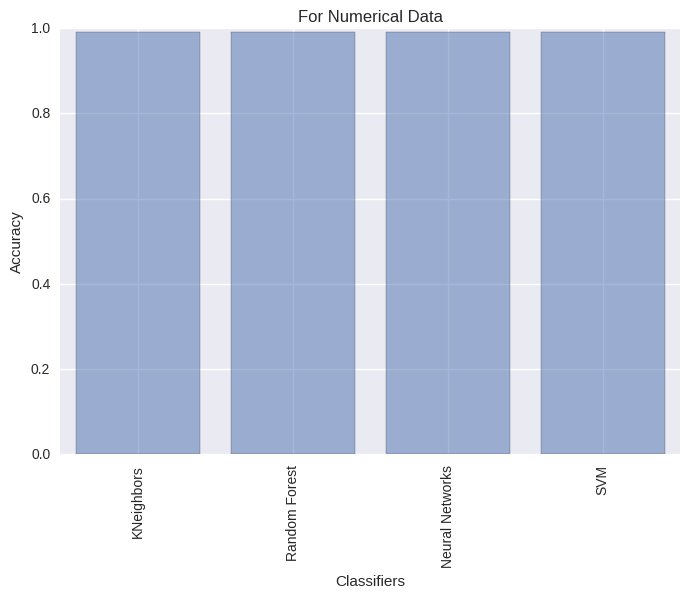

In [36]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn


names = ["KNeighbors", "Random Forest", "Neural Networks", "SVM"]
y_pos = np.arange(len(names))

classifiers = [
    KNeighborsClassifier(10),
    RandomForestClassifier(n_estimators=50),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(40, 20), random_state=1),
    SVC(C=100.),
    ]   

test = pd.DataFrame(names)
accuracy1 = []
accuracy2 = []
accuracy3 = []

print "For Numerical Data\n"
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    accu = metrics.accuracy_score(clf.predict(X_test), y_test)
    print 'accuracy of "{}" model is {}' .format(name, accu)
    accuracy1.append(accu)
    #print name
print "\n"

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('For Numerical Data')
plt.bar(y_pos, accuracy1, align='center', alpha=0.5)
plt.xticks(y_pos, names, rotation='vertical')
plt.show()

### Run 10-fold cross-validation and calculate the mean accuracy of the model

In [37]:
interval = len(y)/10
#print "len of y3 is {}".format(len(Y3))
aucs =[]
rf_cl = RandomForestClassifier(n_estimators=50)

for i in range(0,10):
    X_test = X[i*interval:(i+1)*interval]
    y_test = y[i*interval:(i+1)*interval]
    #X_train = reviews[0:i*interval].append(reviews[(i+1)*interval:])
    #Y_train = data['positive'][0:i*interval]#.append(data['positive'][(i+1)*interval:])
    X_train = np.append(X[0:i*interval],X[(i+1)*interval:],axis=0)
    y_train = np.append(y[0:i*interval],y[(i+1)*interval:],axis=0)
    
    
    rf_cl.fit(X_train, y_train)
    
    acc = metrics.accuracy_score(rf_cl.predict(X_test), y_test)
    
    print "accuracy is {} with fold {}".format(acc, i+1)
    aucs.append(acc)

print "mean accuracy is {}".format(np.mean(aucs))

accuracy is 0.99298245614 with fold 1
accuracy is 0.991228070175 with fold 2
accuracy is 0.991228070175 with fold 3
accuracy is 0.989473684211 with fold 4
accuracy is 0.994736842105 with fold 5
accuracy is 0.994736842105 with fold 6
accuracy is 0.989473684211 with fold 7
accuracy is 0.991228070175 with fold 8
accuracy is 0.99298245614 with fold 9
accuracy is 0.99298245614 with fold 10
mean accuracy is 0.992105263158
